<a href="https://colab.research.google.com/github/Aser-Abdelfatah/Portugal-Wildfire-Clustering/blob/main/Portugal_Dataset_Extraction/Creating_Pandas_Dataframe_to.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Notebook is for creating a Pandas dataframe where each row is a vector corresponding to a point where fire happened in Portugal in a given x, y, and time followed by a list of meteorological and intrinsic features.
## The source of the data is Mesogeos datacube.
## Datacube Source: https://github.com/Orion-AI-Lab/mesogeos/tree/main
## Portugal Shapefile Source: https://geodata.lib.utexas.edu/catalog/stanford-tq087tk3612
## Created by Aser Atawya for wildfire clustering project as part of Beculer Lab at University of Lausanne





# Imports and Installing dependencies (dependencies list is not minimal)


In [1]:
!pip install zarr
!pip install sklearn-som
!pip install minisom
!pip install rasterio
!pip install rioxarray
!pip install geojson
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 57.4 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=ca1d7fa41397033dad2d46a558d3a9897bab6134d824ec50210addfd39abcd01
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=80e2225ccb10eaf980c11ff607b1c865d2cb3c635c15860ebe7df62d3daba1f1
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler, scale
from minisom import MiniSom
from sklearn_som.som import SOM
from sklearn import datasets
import numpy as np
from osgeo import gdal
import rasterio as rio
import geopandas
import rasterio.features
import rioxarray
import geojson
import pandas as pd
from datetime import date, timedelta, datetime
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
import math
pd.set_option('display.max_columns', None)

import scipy.stats as stats
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from shapely.geometry import mapping
from shapely.ops import cascaded_union
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Accessing Data

In [3]:
ds = xr.open_zarr('/content/drive/MyDrive/mesogeos/mesogeos_cube.zarr/', decode_coords=all)

In [4]:
ds

<xarray.Dataset>
Dimensions:               (y: 1752, x: 4714, time: 6026)
Coordinates:
  * time                  (time) datetime64[ns] 2006-04-01 ... 2022-09-29
  * x                     (x) float64 -10.72 -10.71 -10.7 ... 36.72 36.73 36.74
  * y                     (y) float64 47.7 47.69 47.68 ... 30.09 30.08 30.07
Data variables: (12/30)
    aspect                (y, x) float32 dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    burned_areas          (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    curvature             (y, x) float32 dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    d2m                   (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    dem                   (y, x) float32 dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    ignition_points       (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    ...                    ...
    spatial_ref           int64 ...
    ssrd                  (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    t2m                   (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    tp                    (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    wind_direction        (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    wind_speed            (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>

In [5]:
# slice a rectangle including Portugal from original dataset to speeden masking
# Those points represent the eastmost, westmost, northmost, and southmost points in Portugal mainland
ds_portugal = ds.sel(x=slice(-9.50,-6.20), y=slice( 42.16, 36.96))

In [6]:
ds_portugal

<xarray.Dataset>
Dimensions:               (y: 516, x: 327, time: 6026)
Coordinates:
  * time                  (time) datetime64[ns] 2006-04-01 ... 2022-09-29
  * x                     (x) float64 -9.491 -9.481 -9.471 ... -6.218 -6.208
  * y                     (y) float64 42.15 42.14 42.13 ... 36.99 36.98 36.97
Data variables: (12/30)
    aspect                (y, x) float32 dask.array<chunksize=(516, 327), meta=np.ndarray>
    burned_areas          (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    curvature             (y, x) float32 dask.array<chunksize=(516, 327), meta=np.ndarray>
    d2m                   (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    dem                   (y, x) float32 dask.array<chunksize=(516, 327), meta=np.ndarray>
    ignition_points       (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    ...                    ...
    spatial_ref           int64 ...
    ssrd                  (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    t2m                   (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    tp                    (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    wind_direction        (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    wind_speed            (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>

In [7]:
portugal = geopandas.read_file('/content/drive/MyDrive/data/tq087tk3612.shp', crs="epsg:4326")

In [8]:
portugal

,id_0,iso,name_engli,name_iso,name_fao,name_local,name_obsol,name_varia,name_nonla,name_frenc,...,caricom,eu,can,acp,landlocked,aosis,sids,islands,ldc,geometry
0,182.0,PRT,Portugal,PORTUGAL,Portugal,Portugal,NaN,Azores|Madeira,NaN,Portugal,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-16.05835 30.03020, -16.05837 ..."


In [9]:
ds_portugal.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
ds_portugal.rio.write_crs("epsg:4326", inplace=True)

clipped = ds_portugal.rio.clip(portugal.geometry.apply(mapping), portugal.crs, drop=True, from_disk =True)

In [10]:
np.count_nonzero(np.isnan(clipped['roads_distance'].values))
# This is the number of 1*1 km squares there were filtered out and converted to NaN

76456

In [11]:
np.count_nonzero(~np.isnan(clipped['roads_distance'].values))
# This is the number of remaining 1*1 km squares

91949

### While we have 76456 squares that are Nans, we can't remove them because the datacube is structred as X,Y coordinates that represent 2D array i.e. rectangle.

# Visualizations of the clipped datacube

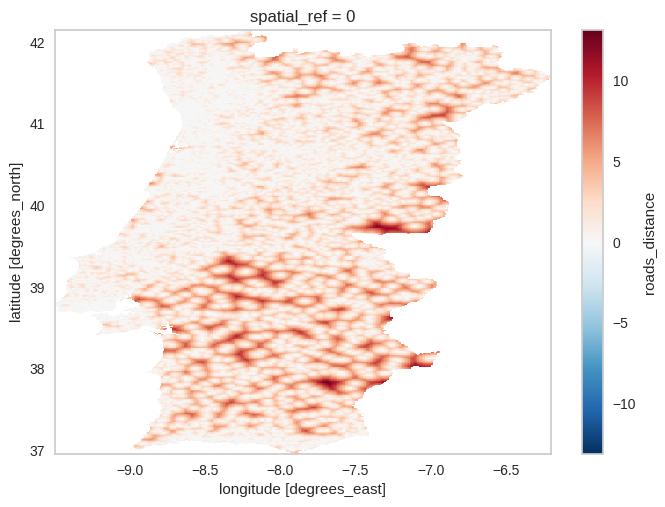

In [12]:
clipped.roads_distance.plot()

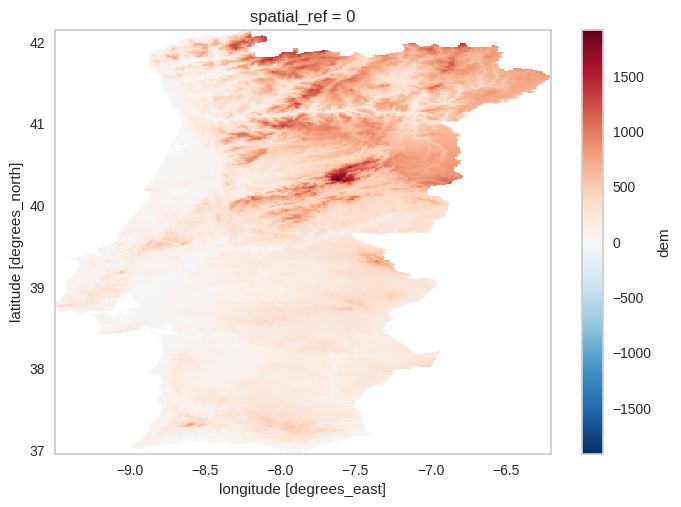

In [13]:
clipped.dem.plot()

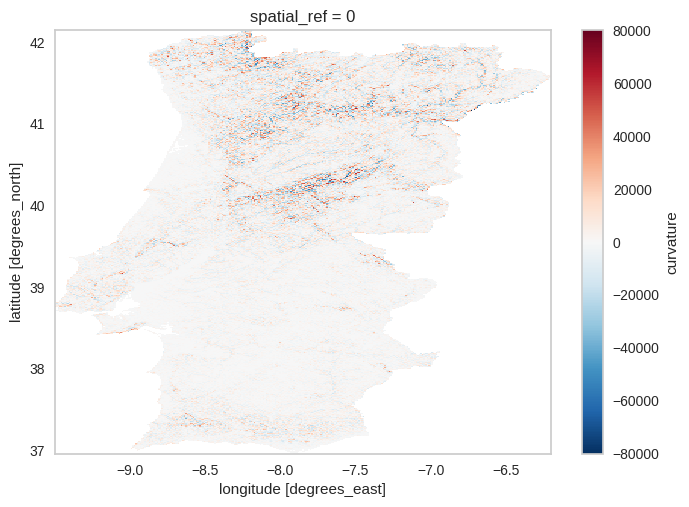

In [14]:
clipped.curvature.plot()

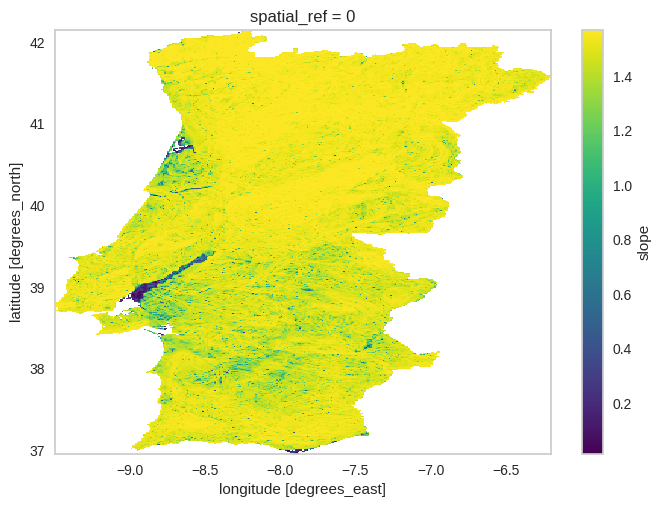

In [15]:
clipped.slope.plot()

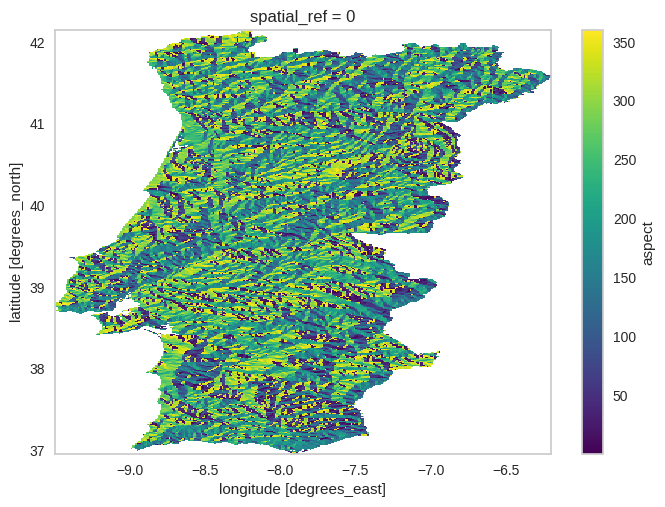

In [16]:
clipped.aspect.plot()

#Creating Pandas dataframe


In [17]:
# function to loop over days in a given data range
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [21]:
# extract variable names of the data cube and omit spatial_ref since it's empty
colnames = []
for var in clipped.variables:
  if var == 'spatial_ref':
      pass
  else:
    colnames.append(var)
# order the variables such that x, y, and time are in the beginnig
colnames[2], colnames[3] = colnames[3], colnames[2]

In [23]:
lst = []
vec_lst = []
# for the start and end data, extracting one year takes roughly 1 and half hour using Google Collab.
# I recommend extracting each year separately, and then concating all the resulting pandas
start_date = date(2006, 04, 1)
end_date = date(2022, 09, 29)

for single_date in daterange(start_date, end_date):
  day = single_date.strftime("%Y-%m-%d")
  lst = []
  for var in colnames:
    # these variables are time-indexed
    if var not in ['aspect', 'curvature', 'dem', 'roads_distance', 'slope']:
      lst.append(np.asarray(clipped.sel(time = day)[var]))
    # these variables are not time-indexed (aspect, curvature, etc.)
    else:
      lst.append(np.asarray(clipped[var]))

  # create vector(list) for each point in x, y, and t
  for y in range(515): #515 values for y coordinate
    for x in range(327): #327 values for x coordinate
      vector = []
      # lst[4][y][x] > 0 ensures a fire happened in that point at given x, y, t
      #  ~np.isnan(lst[23][y][x]) ensures this point is inside Portugal
      if ~np.isnan(lst[23][y][x]) and lst[4][y][x] > 0:
        # x coordinate
        vector.append(lst[0][x])
        # y coordinate
        vector.append(lst[1][y])
        # time t
        vector.append(day)
        for i in range(3, 32):
          # add all the values
          vector.append(lst[i][y][x])
        vec_lst.append(vector)

In [ ]:
years = pd.DataFrame(data = vec_lst, columns = colnames)

In [26]:
# Edit the path to be to your desired path on your Google drive
# Recommend saving data at this point to avoid re-running the time-consuming code above if runtime session was lost
years.to_csv('/content/drive/MyDrive/data/data_before_handling.csv')

In [42]:
# Those variables are updated annually, and the 1st Jan of each year has the values of the year
cols = ['lc_agriculture', 'lc_forest', 'lc_grassland', 'lc_settlement', 'lc_shrubland', 'lc_sparse_vegetation', 'lc_water_bodies', 'lc_wetland', 'population']

In [ ]:
# handles the variables updated annually
for index1, row1 in years.iterrows():
  for var in cols:
    years.at[index1, var] = (np.asarray(clipped.sel(x = row1['x'], y = row1['y'], method='nearest', time = date(row1['year'], 1, 1).strftime("%Y-%m-%d"))[var]))

In [ ]:
# add multiple date-related features to the dataset, such as year, month, day, and day of the year
for index1, row1 in years.iterrows():
    # extract year, month, and day
    year = int(years['time'].values[index1][0:4])
    month = int(years['time'].values[index1][5:7])
    day = int(years['time'].values[index1][8:10])
    day_of_the_year = date(year, month, day).timetuple().tm_yday
    years.at[index1, 'year'] = year
    years.at[index1, 'month'] = month
    years.at[index1, 'day'] = day
    years.at[index1, 'day_of_the_year'] = day_of_the_year
    # winter days will be close to 1 and summer days will be close to -1
    years.at[index1, 'cos_day_of_the_year'] = math.cos(day_of_the_year * 2 * math.pi/365)
    years.at[index1, 'sin_day_of_the_year'] = math.sin(day_of_the_year * 2 * math.pi/365)

years['year'] = years['year'].astype('int')
years['month'] = years['month'].astype('int')
years['day'] = years['day'].astype('int')
years['day_of_the_year'] = years['day_of_the_year'].astype('int')

In [ ]:
# create 2 columns with values int instead of float for x and y to make it easier for comparisons and data manuiplation for feature engineerng
years['x_int'] = round(years['x'], 3) * 100
years['y_int'] = round(years['y'], 3) * 100
years['x_int'] = years['x_int'].astype('int')
years['y_int'] = years['y_int'].astype('int')

In [ ]:
years = years.sort_values(by=['x_int', 'y_int'])
years = years.reset_index()
years = years.drop(columns=[ 'index'])
years

In [ ]:
# add a new feature to the dataset, which is the number of times a given square was burned in the timeframe of the data
years['repetitions'] = 0
for index1, row1 in years.iterrows():
    x1 = row1['x_int']
    y1 = row1['y_int']
    repeat = 0
    if row1['repetitions'] > 0:
        continue
    for index2 in range(index1, len(years)):
        x2 = years.loc[index2,'x_int']
        y2 = years.loc[index2, 'y_int']
        repetitions =  years.loc[index2, 'repetitions']
        if repetitions > 0:
            years.at[index1, 'repetitions'] = repetitions
            break
        elif x1 == x2 and y1 == y2:
            repeat += 1
        else:
            for i in range(index1, index2):
                years.at[i, 'repetitions'] = repeat
            break
# handle edge case of last element in row
if years.at[len(years) - 1, 'repetitions'] == 0:
    years.at[len(years) - 1, 'repetitions'] = 1